In [1]:
# ===============================================================
# Dataset: UTKFace - Age, Gender, and Ethnicity Dataset
# Kaggle Source: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv
# Original Website: https://susanqq.github.io/UTKFace/
# Google Drive Download Link: https://drive.google.com/drive/folders/1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G
#
# Description:
# The UTKFace dataset contains over 20,000 face images labeled with age, gender, and ethnicity.
# Each image file is named in the format:
# 
#     [age]_[gender]_[race]_[date&time].jpg
#
# Where:
#   [age]     → integer 0–116 (person's age)
#   [gender]  → 0 = male, 1 = female
#   [race]    → 0 = White, 1 = Black, 2 = Asian, 3 = Indian, 4 = Others
#   [date&time] → yyyymmddHHMMSSFFF (timestamp when collected)
#
# Example: 24_0_2_20170116174525125.jpg
# → Age: 24 | Gender: Male | Race: Asian
#
# Note:
# The labels must be extracted from the filenames before training the model.
# We will be training the model locally so we have downloaded the dataset manually.
# Use the above Google Drive link to download the dataset, and update the file paths accordingly.
# ===============================================================
# Image Size Analysis from seperate script:
# ===============================================================
# Total images checked: 24106
# Minimum size: 87x69
# Maximum size: 8198x8739
# 
# No images smaller than 64x64 found.
# ===============================================================


Imports:


In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import cv2

data_path = r"D:\python\Classifier_Model\data_clean"


Data Labeling:

In [3]:
# Lists to hold images and labels
X = []
y_age = []
y_gender = []
y_race = []

# Get all jpg files
image_files = [f for f in os.listdir(data_path) if f.lower().endswith(".jpg")]

print(f"Found {len(image_files)} images. Extracting labels...")

_tracker = 0

for file in image_files:
    _tracker += 1
    if _tracker % 1000 == 0:
        print(f"Processing image {_tracker}/{len(image_files)}")
    try:
        # Open image, convert to RGB, resize, normalize
        img = Image.open(os.path.join(data_path, file)).convert("RGB").resize((128,128))
        X.append(np.array(img)/255.0)

        # Extract labels
        name_only = file.split(".")[0]
        parts = name_only.split("_")
        y_age.append(int(parts[0]))
        y_gender.append(int(parts[1]))
        y_race.append(int(parts[2]))

    except Exception as e:
        print(f"Skipping file {file}: {e}")

# Convert to NumPy arrays
X = np.array(X)  # Shape: (num_images, 128, 128, 3)
y_age = np.array(y_age) # shape: (num_samples,)
y_gender = np.array(y_gender)  # shape: (num_samples,)
y_race = to_categorical(y_race, num_classes=5) # shape: (num_samples, 5)

# X[0]        -> image 1
# y_age[0]    -> age of image 1
# y_gender[0] -> gender of image 1
# y_race[0]   -> race of image 1

print(f"Processed {len(X)} images successfully!")

Found 24101 images. Extracting labels...
Processing image 1000/24101
Processing image 2000/24101
Processing image 3000/24101
Processing image 4000/24101
Processing image 5000/24101
Processing image 6000/24101
Processing image 7000/24101
Processing image 8000/24101
Processing image 9000/24101
Processing image 10000/24101
Processing image 11000/24101
Processing image 12000/24101
Processing image 13000/24101
Processing image 14000/24101
Processing image 15000/24101
Processing image 16000/24101
Processing image 17000/24101
Processing image 18000/24101
Processing image 19000/24101
Processing image 20000/24101
Processing image 21000/24101
Processing image 22000/24101
Processing image 23000/24101
Processing image 24000/24101
Processed 24101 images successfully!


Split for training/validation

In [4]:
# Split into train (80%) and test (20%)
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test, y_race_train, y_race_test = train_test_split(
    X, y_age, y_gender, y_race, test_size=0.2, random_state=42
)

# Further split the training set into train (90%) and validation (10%)
X_train, X_val, y_age_train, y_age_val, y_gender_train, y_gender_val, y_race_train, y_race_val = train_test_split(
    X_train, y_age_train, y_gender_train, y_race_train, test_size=0.1, random_state=42
)
# Result: 72% train, 20% test, 8% validation

Data Augmentation (Might be useful to add more "uniqueness", but commented out for now since we have enough variation)

In [5]:
# datagen = ImageDataGenerator(
#     rotation_range=10,       # small rotation (faces shouldn't flip upside down)
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     brightness_range=[0.8, 1.2],
#     horizontal_flip=True,    # optional (can help for gender/ethnicity)
# )

Define CNN

In [35]:
# ===============================================================
# Define CNN
# ===============================================================

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

# CNN feature extractor
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Multiple outputs
age_output = layers.Dense(1, name='age')(x)  # regression
gender_output = layers.Dense(1, activation='sigmoid', name='gender')(x)  # binary classification
race_output = layers.Dense(5, activation='softmax', name='race')(x)  # 5-class classification

# Define the model
model = Model(inputs=inputs, outputs=[age_output, gender_output, race_output])

# Compile it
model.compile(
    optimizer='adam',
    loss={
        'age': 'mae',             # mean absolute error for regression
        'gender': 'binary_crossentropy',
        'race': 'categorical_crossentropy'
    },
    metrics={
        'age': 'mae',
        'gender': 'accuracy',
        'race': 'accuracy'
    }
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  8,388,864 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │        257 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │        257 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race (Dense)        │ (None, 5)         │      1,285 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,483,911 (32.36 MB)

 Trainable params: 8,483,911 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

Train CNN

In [36]:
# Early stopping callback: stops training if val_loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',   # you can also monitor 'val_age_loss', 'val_gender_accuracy', etc.
    patience=5,           # number of epochs to wait after last improvement
    restore_best_weights=True  # revert to the best weights
)

# Optional: reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # reduce LR by this factor
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, [y_age_train, y_gender_train, y_race_train],
    validation_data=(X_val, [y_age_val, y_gender_val, y_race_val]),
    epochs=1000,  # set a high number; early stopping will halt it automatically
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/1000
543/543 ━━━━━━━━━━━━━━━━━━━━ 75s 135ms/step - age_loss: 15.1781 - age_mae: 15.1720 - gender_accuracy: 0.5873 - gender_loss: 0.7237 - loss: 17.5564 - race_accuracy: 0.3784 - race_loss: 1.6601 - val_age_loss: 13.6974 - val_age_mae: 13.5846 - val_gender_accuracy: 0.6815 - val_gender_loss: 0.6002 - val_loss: 15.5236 - val_race_accuracy: 0.4621 - val_race_loss: 1.3386 - learning_rate: 0.0010
Epoch 2/1000
543/543 ━━━━━━━━━━━━━━━━━━━━ 73s 134ms/step - age_loss: 14.3212 - age_mae: 14.3231 - gender_accuracy: 0.6529 - gender_loss: 0.6235 - loss: 16.3515 - race_accuracy: 0.4323 - race_loss: 1.4047 - val_age_loss: 13.0575 - val_age_mae: 12.9407 - val_gender_accuracy: 0.6872 - val_gender_loss: 0.5713 - val_loss: 14.8531 - val_race_accuracy: 0.4487 - val_race_loss: 1.3437 - learning_rate: 0.0010
Epoch 3/1000
543/543 ━━━━━━━━━━━━━━━━━━━━ 73s 135ms/step - age_loss: 13.6062 - age_mae: 13.6021 - gender_accuracy: 0.6739 - gender_loss: 0.5974 - loss: 15.5583 - race_accuracy: 0.4545 - race_los

History plotted

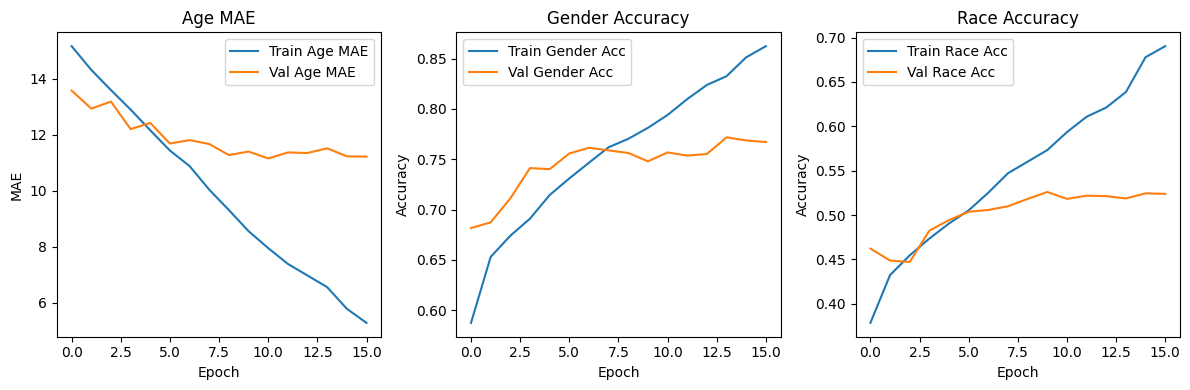

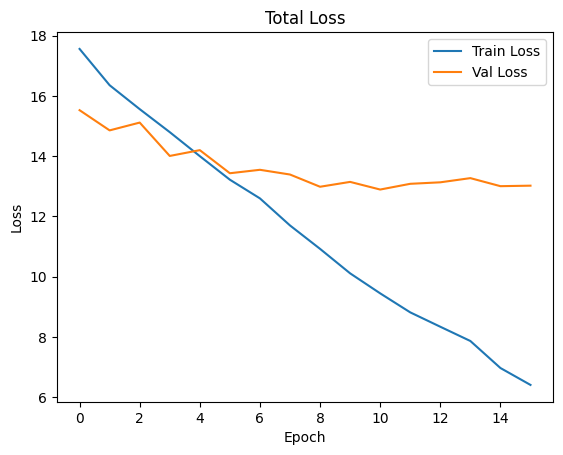

In [37]:
# Access history dictionary
history_dict = history.history

# Plot Age MAE
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history_dict['age_mae'], label='Train Age MAE')
plt.plot(history_dict['val_age_mae'], label='Val Age MAE')
plt.title('Age MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot Gender Accuracy
plt.subplot(1,3,2)
plt.plot(history_dict['gender_accuracy'], label='Train Gender Acc')
plt.plot(history_dict['val_gender_accuracy'], label='Val Gender Acc')
plt.title('Gender Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Race Accuracy
plt.subplot(1,3,3)
plt.plot(history_dict['race_accuracy'], label='Train Race Acc')
plt.plot(history_dict['val_race_accuracy'], label='Val Race Acc')
plt.title('Race Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Optional: plot total loss
plt.figure()
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model save

In [41]:
# Save the model after training
model.save("face1_model.keras")
print("Model saved successfully!")

Model saved successfully!


Static test

In [43]:
# Load your model if needed
# model = load_model('my_model.h5')

# Load and preprocess a test image
img_path = r"D:\python\Classifier_Model\test\Jensen_Huang.jpg"
img = Image.open(img_path).convert("RGB").resize((128,128))
x = np.array(img)/255.0
x = np.expand_dims(x, axis=0)  # shape: (1, 128, 128, 3)

# Predict
age_pred, gender_pred, race_pred = model.predict(x)
print(f"Predicted Age: {age_pred[0][0]:.0f}")
print(f"Predicted Gender: {'Male' if gender_pred[0][0] < 0.5 else 'Female'}")
print(f"Predicted Race: {np.argmax(race_pred[0])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Age: 58
Predicted Gender: Male
Predicted Race: 1


Live camera test w/ boxes

In [39]:
# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

cap = cv2.VideoCapture(0)  # 0 = default webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # Loop over detected faces
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        x_input = np.expand_dims(img/255.0, axis=0)

        # Predict
        age_pred, gender_pred, race_pred = model.predict(x_input)
        age = int(age_pred[0][0])
        gender = "Male" if gender_pred[0][0] < 0.5 else "Female"
        race = np.argmax(race_pred[0])

        # Draw rectangle and overlay prediction
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, f"{age}, {gender}, {race}", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    cv2.imshow("UTKFace Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

Live camera w/o boxes

In [ ]:
cap = cv2.VideoCapture(0)  # 0 = default webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Preprocess the frame
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128,128))
    x = np.expand_dims(img/255.0, axis=0)
    
    # Predict
    age_pred, gender_pred, race_pred = model.predict(x)
    age = int(age_pred[0][0])
    gender = "Male" if gender_pred[0][0] < 0.5 else "Female"
    race = np.argmax(race_pred[0])
    
    # Display predictions on the frame
    cv2.putText(frame, f"{age}, {gender}, {race}", (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow("UTKFace Prediction", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()